<h1 align='center'>Deteccion de anomalías en grandes volúmenes de datos</h1>


## Análisis del dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab

In [2]:
df = pd.read_csv('input/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ahora determinamos la cantidad de transacciones fraudulentas en el dataset.

In [4]:
frauds = (df['Class'] == 1)

In [5]:
len(df[frauds])

492

In [6]:
len(df)

284807

Lo anterior nos indica que de las $284,807$ transacciones en el dataset, $492$ corresponden a transacciones fraudulentas, de modo que el resto de transacciones, $284,315$, son transacciones normales. Podemos visualizar esto en un gráfico de pastel.

<AxesSubplot:>

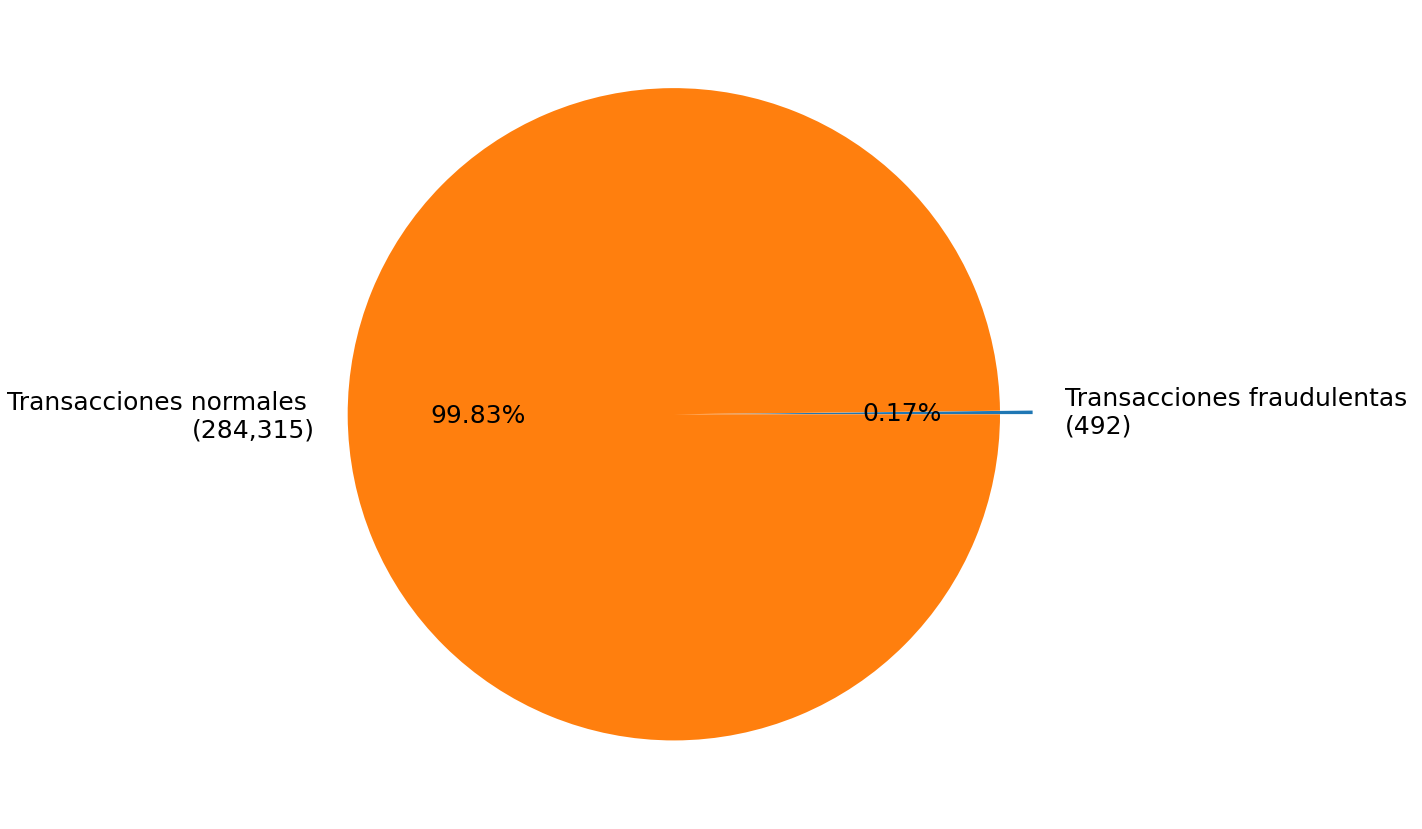

In [7]:
plot_data = pd.DataFrame({ 'Tipo de transacción': ['Transacciones fraudulentas \n(492)', 'Transacciones normales \n(284,315)'],
                  'Cantidad': [492, 284315]})

plot_data.set_index('Tipo de transacción', inplace=True)
plot = plot_data.plot.pie(y='Cantidad', legend=False, \
                   autopct='%1.2f%%', explode=(0, 0.1), \
                   shadow=False, startangle=0, figsize=(15, 15), fontsize=25);
pylab.ylabel('')
plot

Podemos verificar que en este dataset no hay datos nulos:

In [8]:
df.isnull().values.any()

False

In [9]:
df.isnull().sum().sum()

0

## Matriz de correlación

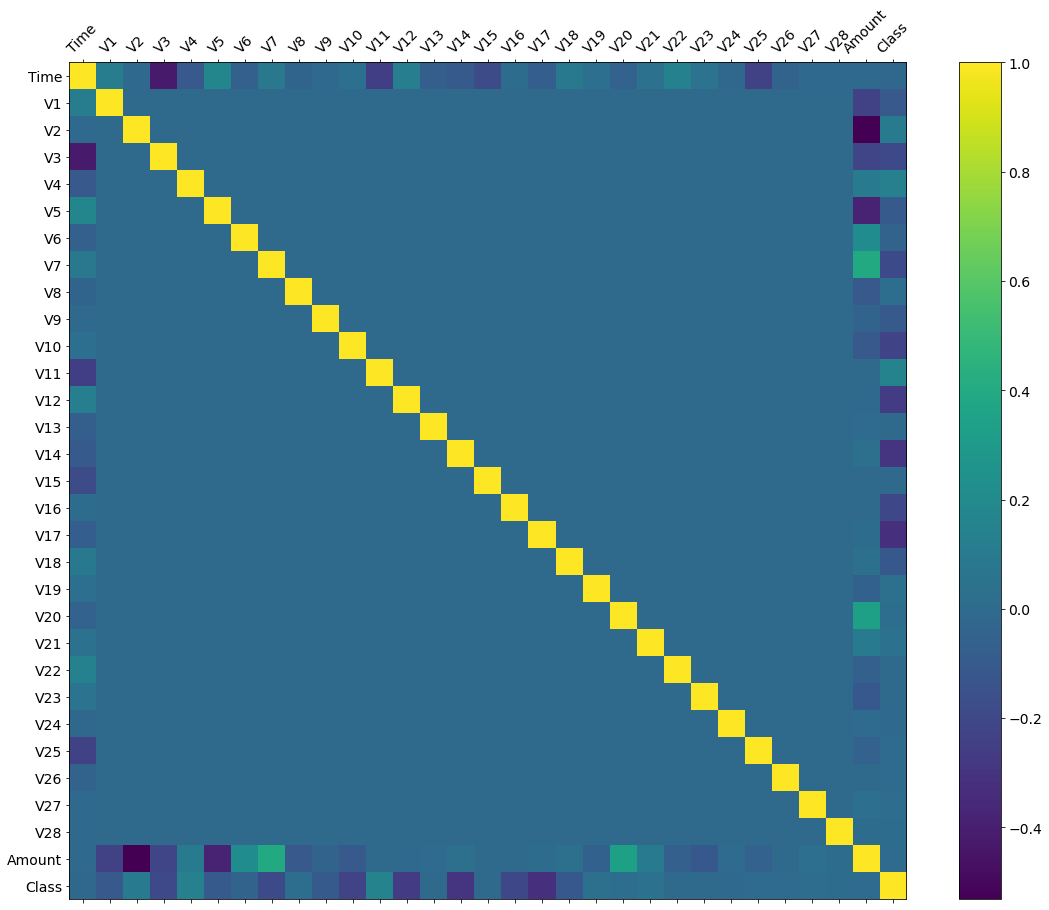

In [10]:
f = plt.figure(figsize=(19, 15))
corrMatrix = df.corr()
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

## Preprocesamiento

### Separando en conjuntos de entrenamiento y de prueba

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

# Generando conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

### Escalando columnas

In [12]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

scaled_train_amount = robust_scaler.fit_transform(train_data['Amount'].values.reshape(-1,1))
scaled_train_time = robust_scaler.fit_transform(train_data['Time'].values.reshape(-1,1))

train_data.drop(['Amount', 'Time'], axis=1, inplace=True)
train_data.insert(0, 'scaled_amount', scaled_train_amount)
train_data.insert(1, 'scaled_time', scaled_train_time)

train_data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
186472,2.467243,0.499741,1.780530,-1.258788,-1.258463,-0.388690,-1.090031,-0.984871,-0.674295,-0.179952,...,0.371207,0.350977,0.690090,-0.044322,-0.110432,-0.241824,-0.103021,-0.003853,0.018913,0
9985,-0.149428,-0.817960,-1.372980,1.779108,0.994216,0.290827,-0.849137,-1.171900,-0.114772,0.704321,...,-0.064964,-0.307072,-0.785944,0.137961,0.622579,-0.171850,0.022442,0.106223,0.035918,0
214733,0.097296,0.648739,-0.927206,-0.725931,0.818936,-0.552991,0.558724,-0.535803,0.086743,0.137233,...,-0.338850,-0.228540,-0.427330,1.049918,-0.458899,-0.679002,0.191879,0.037741,-0.076710,0
148004,-0.292863,0.054875,2.050541,-0.364329,-2.542955,-0.729276,2.388357,3.318051,-0.479005,0.791533,...,-0.154774,-0.293302,-0.834855,0.381652,0.698185,-0.264835,0.219264,-0.052150,-0.066923,0
198825,0.486758,0.564934,-4.704732,-5.265741,1.012380,1.312295,3.059641,-0.426282,-0.375237,-0.228523,...,-2.167024,-0.529683,2.056484,3.992614,-0.901439,0.098882,0.981082,0.932378,-1.085294,0


### Implementando random undersampling

In [13]:
from sklearn.utils import resample

train_frauds = train_data[train_data.Class == 1]
train_non_frauds = train_data[train_data.Class == 0]

# Extracting the same amount of non frauds as frauds from training set 
downsampled = resample(train_non_frauds, replace=True, n_samples=len(train_frauds), random_state=27)

train_undersampled = pd.concat([train_frauds, downsampled])
train_shuffled = train_undersampled.sample(frac=1, random_state=42)

# Print  
train_shuffled.Class.value_counts()

0    343
1    343
Name: Class, dtype: int64

In [14]:
train_shuffled.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
119714,0.110817,-0.106167,-0.734303,0.435519,-0.530866,-0.471120,0.643214,0.713832,-1.234572,-2.551412,...,0.864536,-1.004877,1.150354,-0.152555,-1.386745,0.004716,0.219146,-0.058257,0.158048,1
37473,0.808336,-0.536086,1.175492,-0.066039,-0.300829,-0.176445,0.089292,-0.490632,0.326379,-0.163510,...,0.140570,-0.397166,-1.371718,0.024296,-0.472851,0.169158,0.647163,-0.116587,-0.001252,0
243699,-0.292724,0.792520,-4.320609,3.199939,-5.799736,6.502330,0.378479,-1.948246,-2.167860,-0.728207,...,-0.263686,0.476660,0.434278,-0.136940,-0.620072,0.642531,0.280717,-2.649107,0.533641,1
150644,0.750767,0.108482,-3.821939,5.667247,-9.244963,8.246147,-4.368286,-3.450735,-8.427378,2.305609,...,1.115247,1.990520,0.083353,-0.062264,0.390188,0.329884,0.098017,1.869570,1.000850,1
9179,-0.292724,-0.839757,-2.880042,5.225442,-11.063330,6.689951,-5.759924,-2.244031,-11.199975,4.014722,...,1.191444,2.002883,0.351102,0.795255,-0.778379,-1.646815,0.487539,1.427713,0.583172,1


<AxesSubplot:>

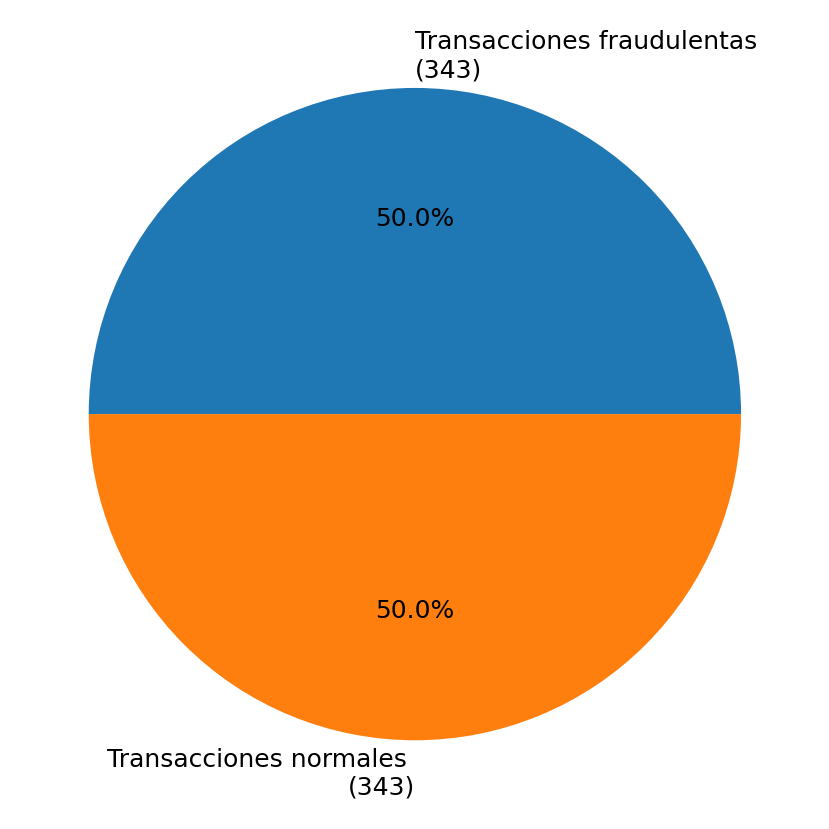

In [15]:
train_shuffled_frauds = len(train_shuffled[train_shuffled.Class==1])
train_shuffled_non_frauds = len(train_shuffled[train_shuffled.Class==0])

plot_data = pd.DataFrame({ 'Tipo de transacción': [
    'Transacciones fraudulentas \n({})'.format(train_shuffled_frauds),
    'Transacciones normales \n({})'.format(train_shuffled_non_frauds)
],
                          'Cantidad': [train_shuffled_frauds, train_shuffled_non_frauds]})

plot_data.set_index('Tipo de transacción', inplace=True)
plot = plot_data.plot.pie(y='Cantidad', legend=False, \
                   autopct='%1.1f%%', \
                   shadow=False, startangle=0, figsize=(15, 15), fontsize=25);
pylab.ylabel('')
plot

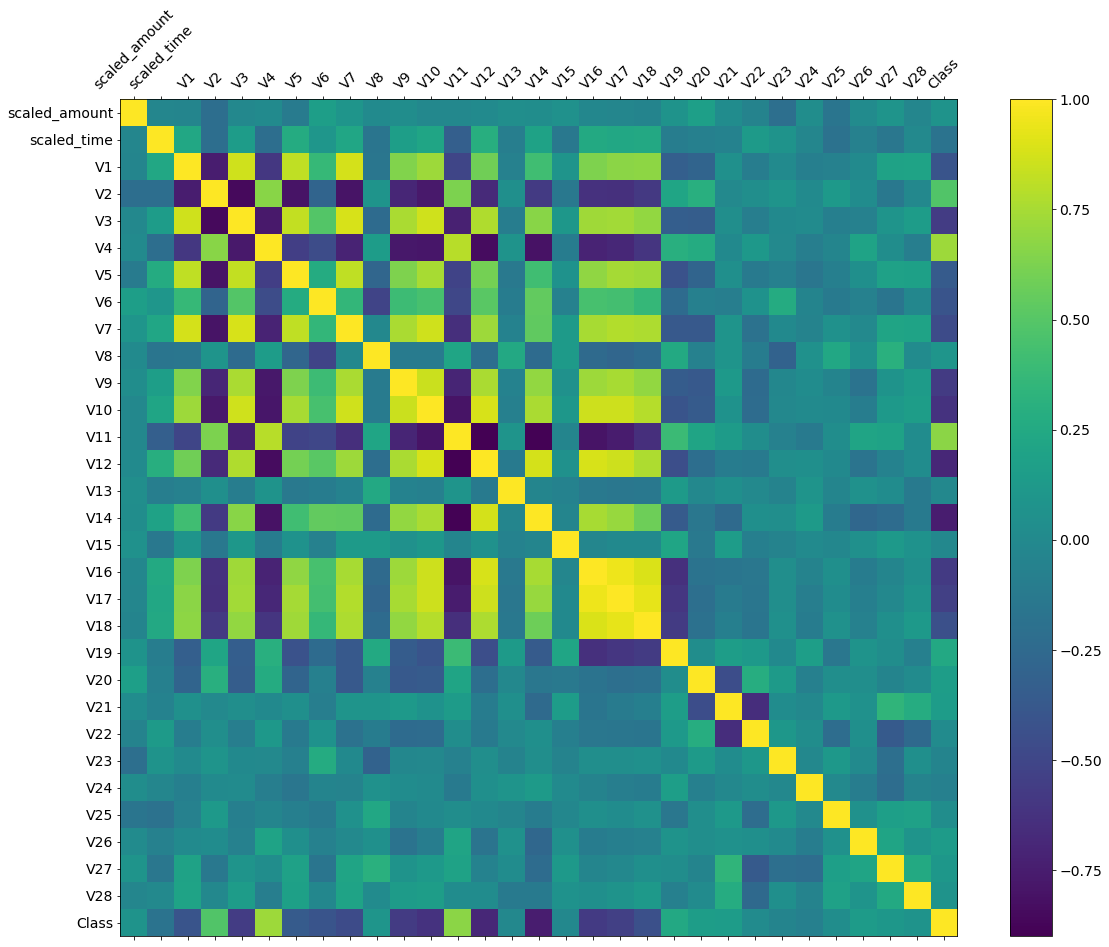

In [16]:
f = plt.figure(figsize=(19, 15))
corrMatrix = train_shuffled.corr()
plt.matshow(corrMatrix, fignum=f.number)
plt.xticks(range(train_shuffled.select_dtypes(['number']).shape[1]), train_shuffled.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(train_shuffled.select_dtypes(['number']).shape[1]), train_shuffled.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)